# Clustering Models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

from sklearn.metrics import rand_score, adjusted_rand_score
from sklearn.metrics import mutual_info_score, normalized_mutual_info_score, adjusted_mutual_info_score
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
from sklearn.metrics import fowlkes_mallows_score

In [2]:
data_clean = "../../data/clean/data_clean.csv"
random_split = 44
random_kmeans = 44

num_cols = ["Term","NoEmp","SecuredSBA","GrDisburs","GrApprov","ApprovSBA"]
target = "Default"

## Hold-Out Method

In [3]:
df = pd.read_csv(data_clean, low_memory=False)

df_train, df_test = train_test_split(df, train_size=0.93, random_state=random_split)

In [4]:
X_train = df_train.drop(columns=[target])
y_train = df_train[target]

X_test = df_test.drop(columns=[target])
y_test = df_test[target]

In [5]:
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Test:  {X_test.shape}, {y_test.shape}\n")

Train: (831986, 18), (831986,)
Test:  (62623, 18), (62623,)



## Feature Scaling

In [6]:
scaler = StandardScaler()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.fit_transform(X_test[num_cols])

X_train.sample(3)

,State,BankState,DifState,Sector,AppYear,AppMonth,Term,NoEmp,Secured,NewExist,Urban,Rural,RevLine,LowDoc,GrDisburs,GrApprov,ApprovSBA,SecuredSBA
427273,38,41,0,20,26,6,0.115377,0.100490,0,0,0,0,0,0,0.720540,0.762049,0.865558,0.806785
457613,20,34,1,7,37,4,1.027103,-0.139232,0,1,1,0,0,0,-0.295095,-0.269577,-0.221465,0.806785
694209,4,5,0,10,30,7,0.115377,0.246987,0,0,0,0,0,0,-0.007390,0.022659,0.086463,0.806785


## K-Means Clustering

### Elbow Method

In [7]:
dict_km = {}
for k in range(1, 11):
    kms = KMeans(n_init=10,
                 n_clusters=k,
                 random_state=random_kmeans).fit(X_train)
    dict_km[k] = kms.inertia_

dict_km

{1: 479971807.82219565,
 2: 273879508.4436069,
 3: 203516551.40806895,
 4: 156809423.04188085,
 5: 134187321.03123218,
 6: 121168863.4928912,
 7: 112722137.05667815,
 8: 105658885.59420499,
 9: 98785691.85519853,
 10: 93135644.58682975}

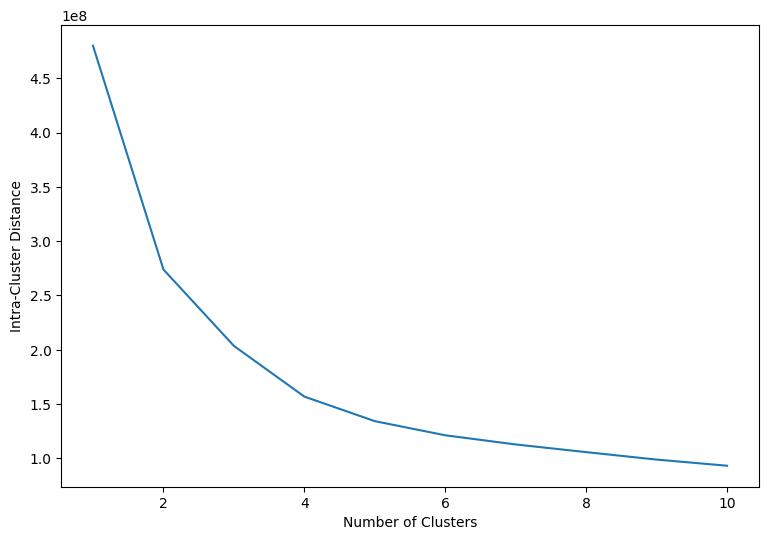

In [8]:
plt.figure(figsize=(9,6))

plt.plot(list(dict_km.keys()), list(dict_km.values()))

plt.xlabel("Number of Clusters")
plt.ylabel("Intra-Cluster Distance")
plt.show()

In [9]:
km_model = KMeans(n_init=10,
                  n_clusters=2, # n_clusters=4
                  random_state=random_kmeans)

km_model.fit(X_train)

KMeans(n_clusters=2, n_init=10, random_state=44)

In [10]:
km_centroids = km_model.cluster_centers_
km_centroids

array([[ 3.22807616e+01,  4.02511486e+01,  4.87706735e-01,
         1.22324592e+01,  3.67218983e+01,  6.47605570e+00,
        -5.92741691e-02, -4.26286245e-03,  1.46362035e-01,
         2.82357488e-01,  5.07796533e-01,  1.24883205e-01,
         2.55577153e-01,  1.27709008e-01, -5.03736174e-02,
        -5.49174364e-02, -6.12885406e-02, -8.52879905e-02],
       [ 1.42246864e+01,  1.44083512e+01,  4.54052551e-01,
         1.22102338e+01,  3.71120295e+01,  6.48891513e+00,
         6.64945006e-02,  4.78213216e-03,  1.96092433e-01,
         2.81047969e-01,  5.39612508e-01,  1.08540694e-01,
         2.22694594e-01,  1.17946194e-01,  5.65097510e-02,
         6.16070636e-02,  6.87542477e-02,  9.56771292e-02]])

In [11]:
km_clusters = km_model.labels_
km_clusters

array([1, 1, 0, ..., 0, 0, 0])

### Eval with Ground Truth

In [12]:
km_labels = km_model.predict(X_test)
km_labels

array([1, 1, 1, ..., 1, 1, 0])

In [13]:
y_km = pd.DataFrame(data=km_labels, columns=["ClusterKM"])

df_test = df_test.reset_index(drop=True)
y_km = y_km.reset_index(drop=True)

In [14]:
df_clu = pd.concat([df_test, y_km], axis=1)
df_clu.sample(7)

,State,BankState,DifState,Sector,AppYear,AppMonth,Term,NoEmp,Secured,NewExist,Urban,Rural,RevLine,LowDoc,GrDisburs,GrApprov,ApprovSBA,SecuredSBA,Default,ClusterKM
46943,49,54,0,10,29,7,120,30,0,1,0,0,0,0,289000,289000,289000,100,0,0
37071,41,45,0,4,31,1,60,1,0,0,0,0,0,1,15000,15000,13500,90,0,0
60472,38,41,0,13,27,4,12,17,0,0,0,0,0,0,150000,150000,126000,84,0,0
32039,34,34,1,12,36,5,140,2,0,0,1,0,0,0,298000,298000,223500,75,1,0
6807,15,17,1,12,42,7,84,16,0,0,1,0,1,0,75496,25000,12500,50,0,1
13389,29,32,0,4,44,12,120,3,0,1,1,0,0,0,531000,531000,398250,75,0,0
17776,43,47,0,4,40,11,72,5,0,0,0,1,0,0,75000,75000,63750,85,0,0


In [15]:
df_km = df_clu[["Default","ClusterKM"]].copy()

df_km = df_km.groupby(["Default","ClusterKM"])["Default"].count()
df_km = df_km.rename("Count").reset_index()

df_km["Frequency"] = round((df_km["Count"] / df_km.groupby("Default")["Count"].transform("sum")) * 100, 2)
df_km

,Default,ClusterKM,Count,Frequency
0,0,0,27583,53.42
1,0,1,24053,46.58
2,1,0,5373,48.90
3,1,1,5614,51.10


In [16]:
print("Exactitud:    %.4f" % (accuracy_score(df_clu["Default"], df_clu["ClusterKM"])))
print("Precisión:    %.4f" % (precision_score(df_clu["Default"], df_clu["ClusterKM"], average="macro")))
print("Sensibilidad: %.4f" % (recall_score(df_clu["Default"], df_clu["ClusterKM"], average="macro")))
print("F1-score:     %.4f" % (f1_score(df_clu["Default"], df_clu["ClusterKM"], average="macro")))

Exactitud:    0.5301
Precisión:    0.5131
Sensibilidad: 0.5226
F1-score:     0.4642


## Hierarchical Clustering

### Plot Dendrogram

In [7]:
hc_model = AgglomerativeClustering(distance_threshold=0,
                                   n_clusters=None)

hc_model = hc_model.fit(X_test)

In [18]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    dendrogram(linkage_matrix, **kwargs)

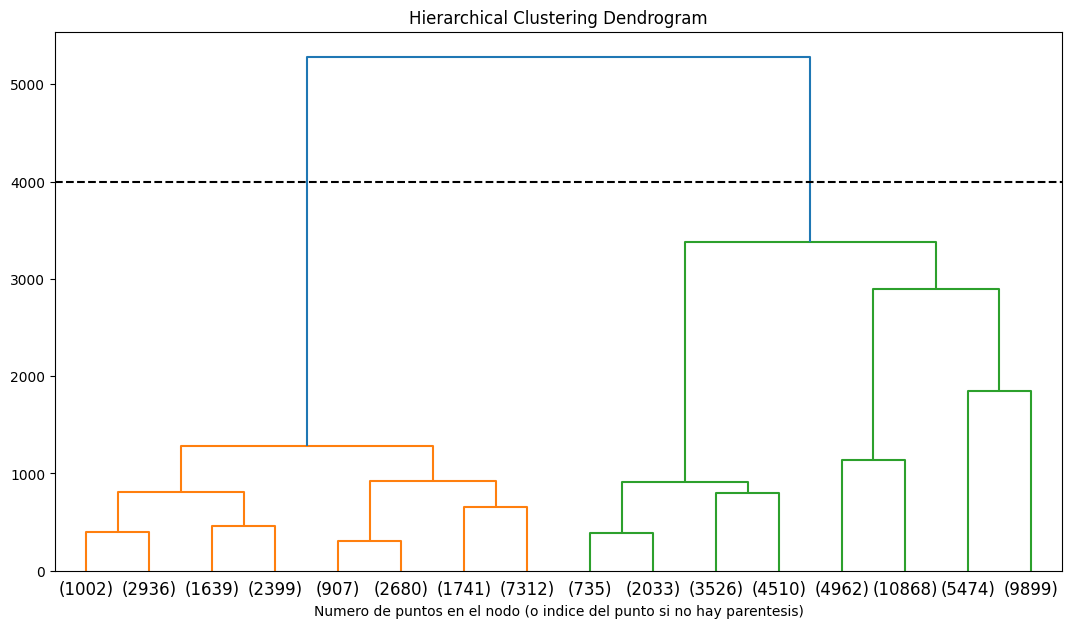

In [19]:
plt.figure(figsize=(13,7))
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(hc_model, truncate_mode="level", p=3)
plt.xlabel("Numero de puntos en el nodo (o indice del punto si no hay parentesis)")
plt.axhline(color="black", linestyle="--", y=4000)
plt.show()

In [21]:
hc_model = AgglomerativeClustering(n_clusters=2)

hc_model = hc_model.fit(X_test)

In [22]:
hc_clusters = km_model.labels_
hc_clusters

array([0, 0, 1, ..., 1, 1, 1], dtype=int32)

### Eval with Ground Truth

In [24]:
hc_labels = hc_model.fit_predict(X_test)
hc_labels

array([0, 0, 0, ..., 0, 0, 1])

In [28]:
y_hc = pd.DataFrame(data=hc_labels, columns=["ClusterHC"])

df_clu = df_clu.reset_index(drop=True)
y_hc = y_hc.reset_index(drop=True)

In [29]:
df_clu = pd.concat([df_clu, y_hc], axis=1)
df_clu.sample(7)

,State,BankState,DifState,Sector,AppYear,AppMonth,Term,NoEmp,Secured,NewExist,...,Rural,RevLine,LowDoc,GrDisburs,GrApprov,ApprovSBA,SecuredSBA,Default,ClusterKM,ClusterHC
6273,34,37,0,16,35,8,60,1,0,0,...,0,0,1,20000,20000,16000,80,0,1,1
50509,48,53,0,13,42,9,90,5,0,1,...,1,0,0,100000,100000,85000,85,0,1,1
58725,5,35,1,8,42,7,84,2,0,1,...,0,1,0,51084,35000,17500,50,0,0,0
11778,4,5,0,10,38,6,60,5,0,0,...,0,1,0,45694,25000,12500,50,0,0,0
52654,43,5,1,20,30,12,246,35,1,0,...,0,0,0,530000,530000,318000,60,0,0,0
56514,4,5,0,20,36,6,294,20,1,1,...,0,0,0,281000,281000,210750,75,0,0,0
154,9,47,1,20,35,11,84,1,0,1,...,0,0,0,192000,192000,144000,75,0,1,0


In [30]:
df_hc = df_clu[["Default","ClusterHC"]].copy()

df_hc = df_hc.groupby(["Default","ClusterHC"])["Default"].count()
df_hc = df_hc.rename("Count").reset_index()

df_hc["Frequency"] = round((df_hc["Count"] / df_hc.groupby("Default")["Count"].transform("sum")) * 100, 2)
df_hc

,Default,ClusterHC,Count,Frequency
0,0,0,33891,65.63
1,0,1,17745,34.37
2,1,0,8116,73.87
3,1,1,2871,26.13


In [31]:
print("Exactitud:    %.4f" % (accuracy_score(df_clu["Default"], df_clu["ClusterHC"])))
print("Precisión:    %.4f" % (precision_score(df_clu["Default"], df_clu["ClusterHC"], average="macro")))
print("Sensibilidad: %.4f" % (recall_score(df_clu["Default"], df_clu["ClusterHC"], average="macro")))
print("F1-score:     %.4f" % (f1_score(df_clu["Default"], df_clu["ClusterHC"], average="macro")))

Exactitud:    0.5870
Precisión:    0.4730
Sensibilidad: 0.4588
F1-score:     0.4528


## Intrinsic Measures

Estas medidas no requieren etiquetas de verdad (ground truth), aplicables a todos los resultados de aprendizaje no supervisado.

### Silhouette Coefficient

Mide la distancia entre clusters frente a la distancia dentro de los clusters, una puntuación más alta significa clusters mejor definidos.

Silhouette Coefficient tiene un rango de [-1, 1], desde un agrupamiento incorrecto hasta un agrupamiento muy denso.

In [32]:
ss_km = silhouette_score(X_test, km_labels, metric="euclidean")
ss_hc = silhouette_score(X_test, hc_labels, metric="euclidean")

In [33]:
print(f"Silhouette Coefficient")
print("-"*30)
print(f"K-Means Clustering: {round(ss_km, 3)}")
print(f"Hierarchical Clustering: {round(ss_hc, 3)}")

Silhouette Coefficient
------------------------------
K-Means Clustering: 0.363
Hierarchical Clustering: 0.33


### Calinski-Harabasz Index

Mide la dispersión entre clusters frente a la dispersión dentro de los clusters, una puntuación más alta significa clústeres mejor definidos.

In [34]:
ch_km = calinski_harabasz_score(X_test, km_labels)
ch_hc = calinski_harabasz_score(X_test, hc_labels)

In [35]:
print(f"Calinski-Harabasz Index")
print("-"*30)
print(f"K-Means Clustering: {round(ch_km, 3)}")
print(f"Hierarchical Clustering: {round(ch_hc, 3)}")

Calinski-Harabasz Index
------------------------------
K-Means Clustering: 47023.015
Hierarchical Clustering: 39239.355


### Davies-Bouldin Index

Mide el tamaño de los clusters frente a la distancia media entre clusters, una puntuación más baja significa clústeres mejor definidos.

In [36]:
db_km = davies_bouldin_score(X_test, km_labels)
db_hc = davies_bouldin_score(X_test, hc_labels)

In [37]:
print(f"Davies-Bouldin Index")
print("-"*30)
print(f"K-Means Clustering: {round(db_km, 3)}")
print(f"Hierarchical Clustering: {round(db_hc, 3)}")

Davies-Bouldin Index
------------------------------
K-Means Clustering: 1.082
Hierarchical Clustering: 1.026


## Extrinsic Measures

Estas medidas requieren etiquetas de verdad (ground truth), que pueden no estar disponibles en la práctica.

### Rand Index (RI, ARI)

Mide la similitud entre las asignaciones de clusters al hacer comparaciones por pares, una puntuacion mas alta significa una mayor similitud.

RI está limitado entre el rango [0, 1] y ARI está limitado entre el rango [-1, 1].

In [39]:
ri_km = rand_score(y_test, km_labels)
ri_hc = rand_score(y_test, hc_labels)

ari_km = adjusted_rand_score(y_test, km_labels)
ari_hc = adjusted_rand_score(y_test, hc_labels)

In [41]:
print(f"Rand Index")
print("-"*30)
print(f"K-Means Clustering: {round(ri_km, 3)}")
print(f"Hierarchical Clustering: {round(ri_hc, 3)}\n")

print(f"Adjusted Rand Index")
print("-"*30)
print(f"K-Means Clustering: {round(ari_km, 3)}")
print(f"Hierarchical Clustering: {round(ari_hc, 3)}")

Rand Index
------------------------------
K-Means Clustering: 0.501
Hierarchical Clustering: 0.515

Adjusted Rand Index
------------------------------
K-Means Clustering: 0.001
Hierarchical Clustering: -0.02


### Mutual Information

Mide el acuerdo entre las asignaciones de clúster; una puntuación más alta significa una mayor similitud.

In [42]:
mi_km = mutual_info_score(y_test, km_labels)
mi_hc = mutual_info_score(y_test, hc_labels)

nmi_km = normalized_mutual_info_score(y_test, km_labels)
nmi_hc = normalized_mutual_info_score(y_test, hc_labels)

ami_km = adjusted_mutual_info_score(y_test, km_labels)
ami_hc = adjusted_mutual_info_score(y_test, hc_labels)

In [43]:
print(f"Mutual Information")
print("-"*30)
print(f"K-Means Clustering: {round(mi_km, 3)}")
print(f"Hierarchical Clustering: {round(mi_hc, 3)}\n")

print(f"Normalized Mutual Information")
print("-"*30)
print(f"K-Means Clustering: {round(nmi_km, 3)}")
print(f"Hierarchical Clustering: {round(nmi_hc, 3)}\n")

print(f"Adjusted Mutual Information")
print("-"*30)
print(f"K-Means Clustering: {round(ami_km, 3)}")
print(f"Hierarchical Clustering: {round(ami_hc, 3)}")

Mutual Information
------------------------------
K-Means Clustering: 0.001
Hierarchical Clustering: 0.002

Normalized Mutual Information
------------------------------
K-Means Clustering: 0.001
Hierarchical Clustering: 0.004

Adjusted Mutual Information
------------------------------
K-Means Clustering: 0.001
Hierarchical Clustering: 0.004


### V-Mesasure

Mide la exactitud de las asignaciones de clusters mediante el análisis de entropía condicional, una puntuación más alta significa una mayor similitud.

In [44]:
h_km = homogeneity_score(y_test, km_labels)
h_hc = homogeneity_score(y_test, hc_labels)

c_km = completeness_score(y_test, km_labels)
c_hc = completeness_score(y_test, hc_labels)

v_km = v_measure_score(y_test, km_labels, beta=1.0)
v_hc = v_measure_score(y_test, hc_labels, beta=1.0)

In [45]:
print(f"Homogeneity")
print("-"*30)
print(f"K-Means Clustering: {round(h_km, 3)}")
print(f"Hierarchical Clustering: {round(h_hc, 3)}\n")

print(f"Completeness")
print("-"*30)
print(f"K-Means Clustering: {round(c_km, 3)}")
print(f"Hierarchical Clustering: {round(c_hc, 3)}\n")

print(f"V-Measure")
print("-"*30)
print(f"K-Means Clustering: {round(v_km, 3)}")
print(f"Hierarchical Clustering: {round(v_hc, 3)}")

Homogeneity
------------------------------
K-Means Clustering: 0.001
Hierarchical Clustering: 0.005

Completeness
------------------------------
K-Means Clustering: 0.001
Hierarchical Clustering: 0.004

V-Measure
------------------------------
K-Means Clustering: 0.001
Hierarchical Clustering: 0.004


### Fowlkes-Mallows Scores

Mide la exactitud de las asignaciones de clusters utilizando Precision y Recall por pares, una puntuación más alta significa una mayor similitud.

In [46]:
fmi_km = fowlkes_mallows_score(y_test, km_labels)
fmi_hc = fowlkes_mallows_score(y_test, hc_labels)

In [47]:
print(f"Fowlkes-Mallows Scores")
print("-"*30)
print(f"K-Means Clustering: {round(fmi_km, 3)}")
print(f"Hierarchical Clustering: {round(fmi_hc, 3)}")

Fowlkes-Mallows Scores
------------------------------
K-Means Clustering: 0.597
Hierarchical Clustering: 0.622
